
# Setting Google drive

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"majdalotaibi","key":"8b788d2d31ab0efc12b7bbc5bf75bf5b"}'}

In [3]:
!pip install -U opendatasets -q
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/msambare/fer2013')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


# Importing the Libraries

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Loading the Dataset & Labeling

In [5]:
base_path = '/content/fer2013'

def create_dataframe(split):
    data = []
    split_path = os.path.join(base_path, split)

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)

        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append([img_path, label])

    return pd.DataFrame(data, columns=['image_path', 'label'])

train_df = create_dataframe('train')
test_df = create_dataframe('test')

# Dataset Exploration

In [6]:
train_df.head()

,image_path,label
0,/content/fer2013/train/sad/Training_3785885.jpg,sad
1,/content/fer2013/train/sad/Training_54656106.jpg,sad
2,/content/fer2013/train/sad/Training_82783771.jpg,sad
3,/content/fer2013/train/sad/Training_51205462.jpg,sad
4,/content/fer2013/train/sad/Training_3384768.jpg,sad


In [7]:
train_df.shape

(28709, 2)

In [8]:
train_df['label'].value_counts()

,count
label,
happy,7215
neutral,4965
sad,4830
fear,4097
angry,3995
surprise,3171
disgust,436


In [9]:
test_df.shape

(7178, 2)

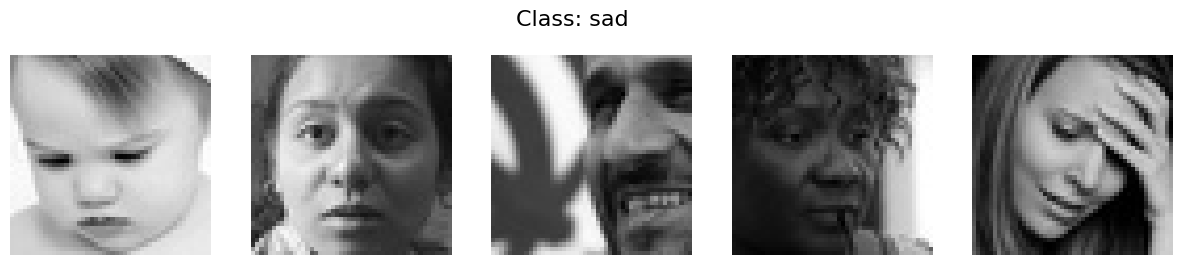

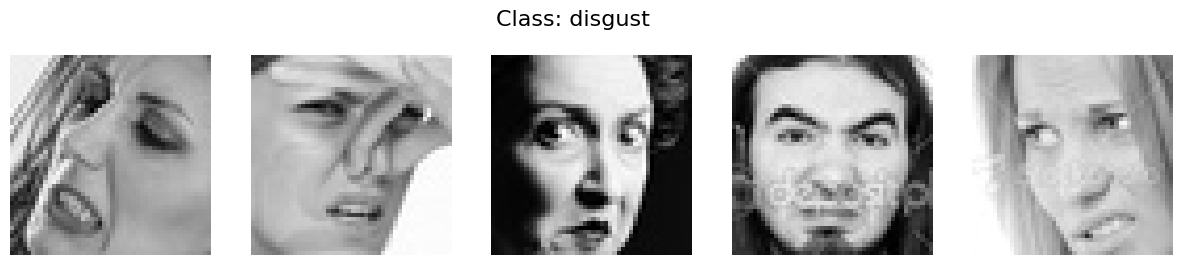

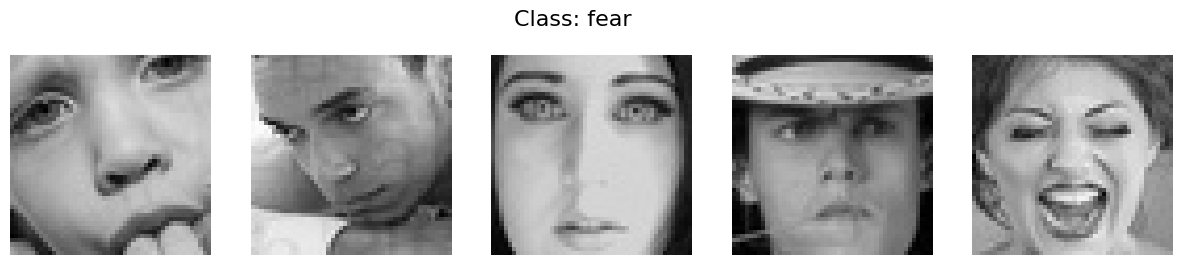

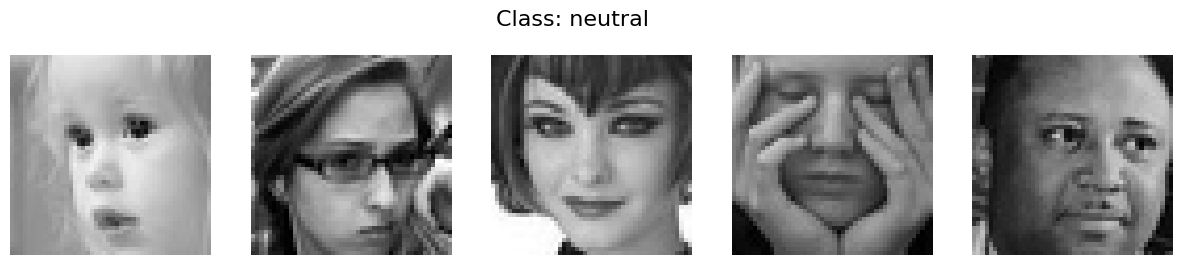

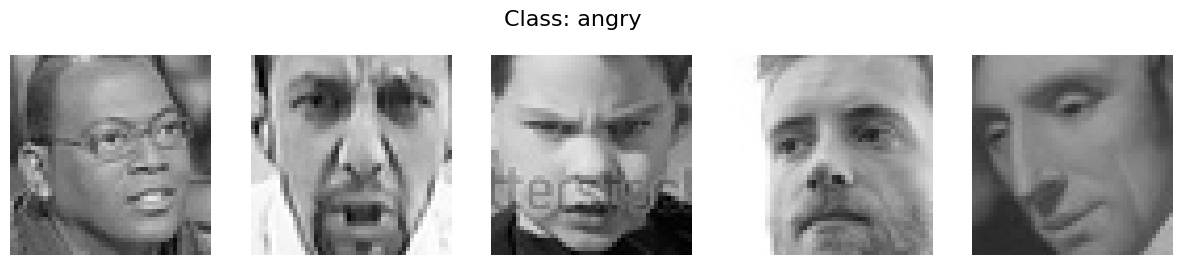

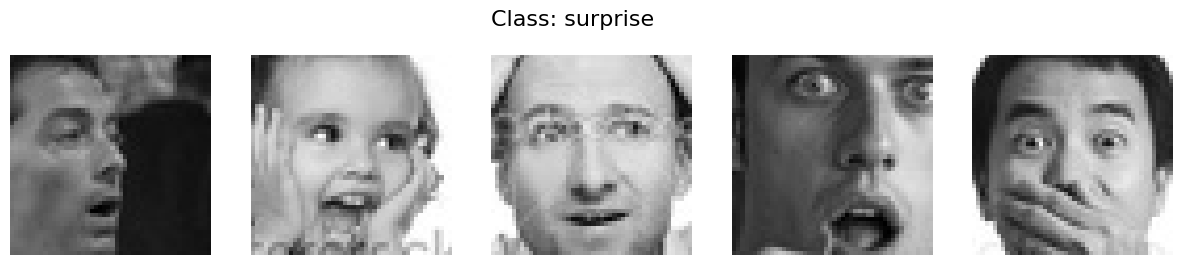

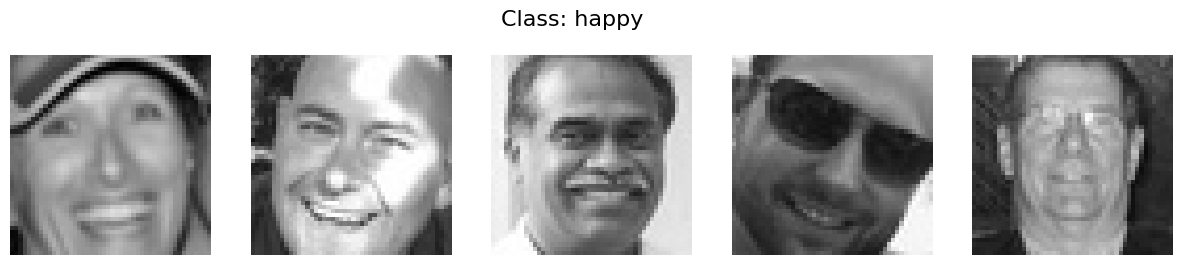

In [10]:
classes = train_df['label'].unique()

for label in classes:
    subset = train_df[train_df['label'] == label].head(5)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Class: {label}', fontsize=16)

    for i, row in enumerate(subset.itertuples(), 1):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Data Splitting

In [11]:
new_train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

print("New train shape:", new_train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

New train shape: (22967, 2)
Validation shape: (5742, 2)
Test shape: (7178, 2)


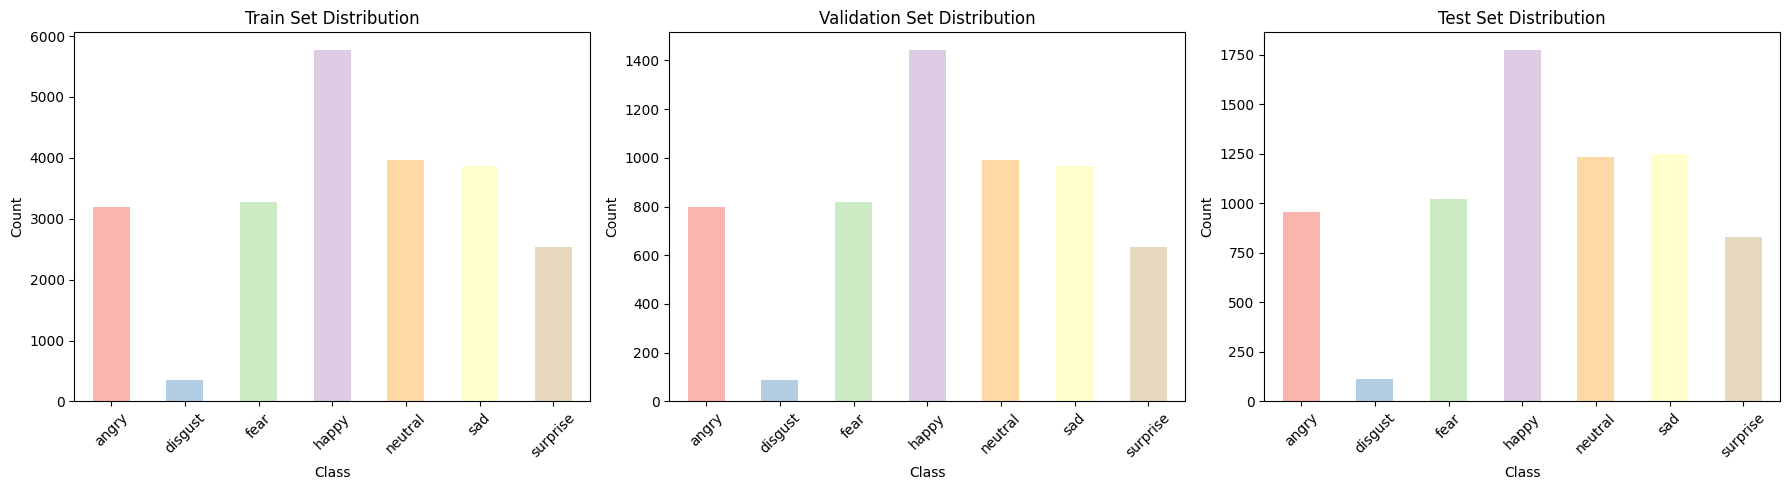

In [12]:
distributions = {
    'Train Set': new_train_df['label'].value_counts().sort_index(),
    'Validation Set': val_df['label'].value_counts().sort_index(),
    'Test Set': test_df['label'].value_counts().sort_index()
}

labels = distributions['Train Set'].index.tolist()
colors = plt.cm.Pastel1.colors

plt.figure(figsize=(18, 5))
for i, (title, dist) in enumerate(distributions.items(), 1):
    plt.subplot(1, 3, i)
    dist.plot(kind='bar', color=colors[:len(labels)])
    plt.title(f'{title} Distribution')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel('Class')

plt.tight_layout()
plt.show()

# Data Augmentation

In [13]:
WIDTH, HEIGHT = 48, 48
batch_size = 64

# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_train_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [14]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Building the CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
model.summary()

# Compiling the Model

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    # optimizer=Adam(lr=0.0001, decay=1e-6),
    # optimizer=Adam(learning_rate=0.0001),
    optimizer='adam',
    metrics=['accuracy']
)

# Training the Model

In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.2396 - loss: 1.8276 - val_accuracy: 0.2997 - val_loss: 1.7210
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.2828 - loss: 1.7440 - val_accuracy: 0.3393 - val_loss: 1.6360
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.3269 - loss: 1.6692 - val_accuracy: 0.4289 - val_loss: 1.4747
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.3952 - loss: 1.5540 - val_accuracy: 0.4669 - val_loss: 1.3692
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4305 - loss: 1.4681 - val_accuracy: 0.4761 - val_loss: 1.3390
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4553 - loss: 1.4241 - val_accuracy: 0.5254 - val_loss: 1.2480
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4703 - loss: 1.3893 - val_accuracy: 0.5247 - val_loss: 1.2320
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.4864 - loss: 1.3439 - 